In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import osmnx as ox
import json

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%pwd

ModuleNotFoundError: No module named 'geopandas'

In [2]:
DATA_PATH = "../../data/"
TAXI_DATA_PATH = "../../data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"

MIN_LAT = 22.5311
MAX_LAT = 22.5517
MIN_LNG = 114.0439
MAX_LNG = 114.0633

DATE_PREFIX = "2020-06-"
START_DAY = 1
END_DAY = 30

DOWNSAMPLING_INTERVAL = 5 #s
TRAJ_SPLIT_INTERVAL = 600
FLOW_AGG_INTERVAL_MINUTE = 5

def notify(msg):
    import datetime
    channel = "J0budaR2THarZw0OqS5O"
    notify_url = f"https://notify.run/{channel}"
    massage = f"{msg} | {str(datetime.datetime.now())}"
    os.system(f'curl {notify_url} -d "{massage}"')

In [50]:
a=np.array([0, 1], dtype=np.int16)
b=a.view(np.float16) # will always use same mem location (i.e. pointer &a==&b), and treat b as float array
print(a)
print(b)
b[0]=1.5
print(a)
print(b)
print("---")
a=np.array([0, 1], dtype=np.int16)
b=a.astype(np.float16, copy=False) # will still copy because int cannot be directly converted to float
print(a)
print(b)
b[0]=1.5
print(a)
print(b)
print("---")
a=np.array([0, 1], dtype=np.int16)
b=a.astype(np.int16, copy=False) # will not copy
print(a)
print(b)
b[0]=1.5
print(a)
print(b)

[0 1]
[0.e+00 6.e-08]
[15872     1]
[1.5e+00 6.0e-08]
---
[0 1]
[0. 1.]
[0 1]
[1.5 1. ]
---
[0 1]
[0 1]
[1 1]
[1 1]


geo

---

In [4]:
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

df_edges

,fid,u,v,geometry
0,0,39,105,"LINESTRING (114.04424 22.55066, 114.04424 22.5..."
1,1,129,36,"LINESTRING (114.04761 22.55094, 114.04768 22.5..."
2,2,36,68,"LINESTRING (114.04768 22.54928, 114.04667 22.5..."
3,3,68,10,"LINESTRING (114.04667 22.54928, 114.04665 22.5..."
4,4,39,10,"LINESTRING (114.04424 22.55066, 114.04665 22.5..."
...,...,...,...,...
487,487,79,45,"LINESTRING (114.06304 22.53372, 114.06297 22.5..."
488,488,73,79,"LINESTRING (114.06305 22.53176, 114.06304 22.5..."
489,489,102,79,"LINESTRING (114.06133 22.53171, 114.06304 22.5..."
490,490,102,73,"LINESTRING (114.06133 22.53171, 114.06305 22.5..."


In [4]:
df_geo=pd.DataFrame()

df_geo["geo_id"]=df_edges["fid"]
df_geo["type"]="LineString"
df_geo["coordinates"]=df_edges["geometry"].apply(lambda x: list(x.coords))

df_geo

,geo_id,type,coordinates
0,0,LineString,"[(114.04423924729905, 22.550663183705367), (11..."
1,1,LineString,"[(114.04761345337049, 22.550935297098224), (11..."
2,2,LineString,"[(114.04767694649549, 22.54928447584822), (114..."
3,3,LineString,"[(114.0466701269419, 22.54928447584822), (114...."
4,4,LineString,"[(114.04423924729905, 22.550663183705367), (11..."
...,...,...,...
487,487,LineString,"[(114.06303991233369, 22.533716708739618), (11..."
488,488,LineString,"[(114.06305083168648, 22.531762144591667), (11..."
489,489,LineString,"[(114.06132557394695, 22.531707547827757), (11..."
490,490,LineString,"[(114.06132557394695, 22.531707547827757), (11..."


In [5]:
df_geo.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.geo"), index=False)

rel

---

In [6]:
rel=[]
rel_id_counter=0

u_dict={}

for _, row in df_edges.iterrows():
    if row["u"] not in u_dict.keys():
        u_dict[row["u"]]=[]
    u_dict[row["u"]].append(row["fid"])
    
for _, row in df_edges.iterrows():
    for adj_fid in u_dict[row["v"]]:
        rel.append([rel_id_counter, "geo", row["fid"], adj_fid])
        rel_id_counter+=1

df_rel=pd.DataFrame(rel, columns=["rel_id", "type", "origin_id", "destination_id"])

df_rel

,rel_id,type,origin_id,destination_id
0,0,geo,0,70
1,1,geo,0,246
2,2,geo,0,252
3,3,geo,1,2
4,4,geo,1,63
...,...,...,...,...
1689,1689,geo,490,244
1690,1690,geo,490,488
1691,1691,geo,491,245
1692,1692,geo,491,489


In [8]:
df_rel.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.rel"), index=False)

dyna

---

In [5]:
df_fmm_res=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "mr.txt"), sep=";").set_index("id").dropna()
df_fmm_data=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "gps.csv"), sep=";", parse_dates=["time"])

df_fmm_res
df_fmm_data

,opath,cpath,mgeom
id,,,
26571,"490,488","490,488","LINESTRING(114.062120071 22.5317326901,114.063..."
40638,"490,242","490,488,242","LINESTRING(114.063050832 22.5317621446,114.063..."
56264,"199,448","199,448","LINESTRING(114.049536389 22.5315155637,114.050..."
43764,"197,444,444","197,198,444","LINESTRING(114.044611299 22.5320412425,114.044..."
46890,"444,199","444,198,199","LINESTRING(114.044632613 22.5314018059,114.044..."
...,...,...,...
1815316,"403,403,403,318,447,447,201,201,203,203,204,20...","403,318,72,157,158,241,243,245,477,476,209,210...","LINESTRING(114.062882667 22.5378549944,114.062..."
1806761,"389,363","389,142,351,363","LINESTRING(114.045371176 22.541687139,114.0469..."
1806762,"211,211,442,439,439,439,183,184,184,184,184,16...","211,202,445,442,195,439,183,184,162,167,169,17...","LINESTRING(114.052873667 22.5315372968,114.051..."


,id,x,y,time,speed
0,0,114.050660,22.551142,2020-06-01 10:07:21,5
1,0,114.050690,22.551117,2020-06-01 10:08:36,9
2,0,114.052180,22.551144,2020-06-01 10:08:51,55
3,0,114.056800,22.551168,2020-06-01 10:09:21,40
4,0,114.057950,22.546215,2020-06-01 10:11:22,23
...,...,...,...,...,...
23599646,1828815,114.057686,22.531790,2020-06-30 09:13:41,30
23599647,1828816,114.043950,22.531195,2020-06-30 15:13:24,58
23599648,1828816,114.051240,22.531390,2020-06-30 15:14:14,41
23599649,1828816,114.054790,22.531458,2020-06-30 15:14:44,57


In [6]:
def convert_path(row):
    row["opath"]=np.array(row["opath"].split(","), dtype=np.int16)
    row["cpath"]=np.array(row["cpath"].split(","), dtype=np.int16)
    
    return row

df_fmm_res=df_fmm_res.apply(convert_path, axis=1)

df_fmm_res

,opath,cpath,mgeom
id,,,
26571,"[490, 488]","[490, 488]","LINESTRING(114.062120071 22.5317326901,114.063..."
40638,"[490, 242]","[490, 488, 242]","LINESTRING(114.063050832 22.5317621446,114.063..."
56264,"[199, 448]","[199, 448]","LINESTRING(114.049536389 22.5315155637,114.050..."
43764,"[197, 444, 444]","[197, 198, 444]","LINESTRING(114.044611299 22.5320412425,114.044..."
46890,"[444, 199]","[444, 198, 199]","LINESTRING(114.044632613 22.5314018059,114.044..."
...,...,...,...
1815316,"[403, 403, 403, 318, 447, 447, 201, 201, 203, ...","[403, 318, 72, 157, 158, 241, 243, 245, 477, 4...","LINESTRING(114.062882667 22.5378549944,114.062..."
1806761,"[389, 363]","[389, 142, 351, 363]","LINESTRING(114.045371176 22.541687139,114.0469..."
1806762,"[211, 211, 442, 439, 439, 439, 183, 184, 184, ...","[211, 202, 445, 442, 195, 439, 183, 184, 162, ...","LINESTRING(114.052873667 22.5315372968,114.051..."


array(['2020-06-01T19:00:07.000000000', '2020-06-01T19:01:47.000000000',
       '2020-06-01T19:05:17.000000000', '2020-06-01T19:06:06.000000000',
       '2020-06-01T19:08:07.000000000', '2020-06-01T19:09:47.000000000',
       '2020-06-01T19:10:47.000000000', '2020-06-01T19:12:06.000000000',
       '2020-06-01T19:13:59.000000000', '2020-06-01T19:14:29.000000000',
       '2020-06-01T19:15:07.000000000', '2020-06-01T19:15:46.000000000',
       '2020-06-01T19:17:10.000000000', '2020-06-01T19:22:26.000000000',
       '2020-06-01T19:23:36.000000000', '2020-06-01T19:24:26.000000000',
       '2020-06-01T19:34:01.000000000'], dtype='datetime64[ns]')

array([444, 456, 474, 473, 234, 459, 451, 425, 168, 328, 326,  80,  81,
        81, 327, 327,  81], dtype=int16)

array([444, 198, 199, 448, 457, 456, 455, 474, 473, 224, 234, 480, 470,
       459, 458, 451, 449, 180, 425, 168, 410, 328, 327, 326,  80,  81,
       327,  81, 327,  81], dtype=int16)

<AxesSubplot:>

<AxesSubplot:>

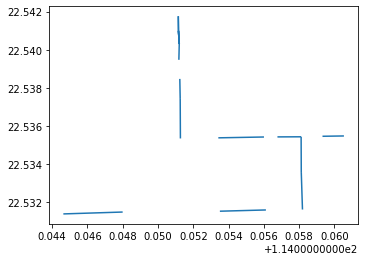

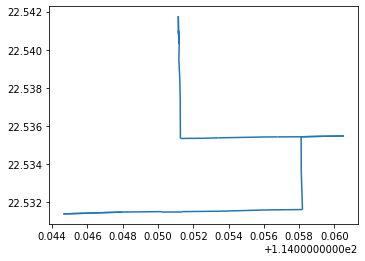

In [6]:
# traj_id=1577

# time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
# opath_list=df_fmm_res.loc[traj_id, "opath"]
# cpath_list=df_fmm_res.loc[traj_id, "cpath"]

# time_list
# opath_list
# cpath_list

# df_edges.loc[opath_list].plot()
# df_edges.loc[cpath_list].plot()

In [7]:
# del_indexes=[]
# for i in range(len(time_list)-1):
#     if opath_list[i]==opath_list[i+1]:
#         del_indexes.append(i+1)

# opath_list=np.delete(opath_list, del_indexes)
# time_list=np.delete(time_list, del_indexes)

# assert(len(opath_list)==len(time_list))
# assert(opath_list[-1]==cpath_list[-1])

# time_list
# opath_list
# cpath_list

array(['2020-06-01T19:00:07.000000000', '2020-06-01T19:01:47.000000000',
       '2020-06-01T19:05:17.000000000', '2020-06-01T19:06:06.000000000',
       '2020-06-01T19:08:07.000000000', '2020-06-01T19:09:47.000000000',
       '2020-06-01T19:10:47.000000000', '2020-06-01T19:12:06.000000000',
       '2020-06-01T19:13:59.000000000', '2020-06-01T19:14:29.000000000',
       '2020-06-01T19:15:07.000000000', '2020-06-01T19:15:46.000000000',
       '2020-06-01T19:17:10.000000000', '2020-06-01T19:23:36.000000000',
       '2020-06-01T19:34:01.000000000'], dtype='datetime64[ns]')

array([444, 456, 474, 473, 234, 459, 451, 425, 168, 328, 326,  80,  81,
       327,  81], dtype=int16)

array([444, 198, 199, 448, 457, 456, 455, 474, 473, 224, 234, 480, 470,
       459, 458, 451, 449, 180, 425, 168, 410, 328, 327, 326,  80,  81,
       327,  81, 327,  81], dtype=int16)

In [13]:
# i=0
# j=0
# recovered_time_list=[]

# while True:
#     if i>len(opath_list)-1:
#         break
#     if opath_list[i]==cpath_list[j]:
#         recovered_time_list.append(time_list[i])
#         i+=1
#         j+=1
#     else:
#         length=0
#         while opath_list[i]!=cpath_list[j]:
#             j+=1
#             length+=1
#         recovered_time_list.extend(gen_time_seq(time_list[i-1], time_list[i], length))
# cpath_list=cpath_list[:j] # fmm bug: trailing
            
# assert(len(recovered_time_list)==len(cpath_list))

# list(zip(cpath_list, recovered_time_list))

[(444, numpy.datetime64('2020-06-01T19:00:07.000000000')),
 (198, numpy.datetime64('2020-06-01T19:00:27.000000000')),
 (199, numpy.datetime64('2020-06-01T19:00:47.000000000')),
 (448, numpy.datetime64('2020-06-01T19:01:07.000000000')),
 (457, numpy.datetime64('2020-06-01T19:01:27.000000000')),
 (456, numpy.datetime64('2020-06-01T19:01:47.000000000')),
 (455, numpy.datetime64('2020-06-01T19:03:32.000000000')),
 (474, numpy.datetime64('2020-06-01T19:05:17.000000000')),
 (473, numpy.datetime64('2020-06-01T19:06:06.000000000')),
 (224, numpy.datetime64('2020-06-01T19:07:06.500000000')),
 (234, numpy.datetime64('2020-06-01T19:08:07.000000000')),
 (480, numpy.datetime64('2020-06-01T19:08:40.333333333')),
 (470, numpy.datetime64('2020-06-01T19:09:13.666666666')),
 (459, numpy.datetime64('2020-06-01T19:09:47.000000000')),
 (458, numpy.datetime64('2020-06-01T19:10:17.000000000')),
 (451, numpy.datetime64('2020-06-01T19:10:47.000000000')),
 (449, numpy.datetime64('2020-06-01T19:11:13.333333333')

In [7]:
# https://stackoverflow.com/questions/35599607/average-date-array-calculation
# https://stackoverflow.com/questions/60949296/how-to-calculate-averages-of-datetime64ns-numpy-ndarray

def gen_time_seq(start_time, end_time, length):
    assert(end_time>start_time)
    
    start_time=start_time.view(np.int64)
    end_time=end_time.view(np.int64)
    
    seq=[]
    step=(end_time-start_time)//(length+1)
    for i in range(length):
        seq.append(start_time+step*(i+1))
    
    return list(np.array(seq, dtype="datetime64[ns]"))

In [ ]:
notify(f"Start {FLOW_AGG_INTERVAL_MINUTE}min recovered dyna.")

N=len(df_edges)

dyna_file=open(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"), "w")
write_length=dyna_file.write("dyna_id,type,time,entity_id,flow,speed\n") # disable printing return value

flow_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)
speed_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int32)
count_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)

for traj_id in tqdm(df_fmm_res.index):
    time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
    speed_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["speed"].values
    opath_list=df_fmm_res.loc[traj_id, "opath"]
    cpath_list=df_fmm_res.loc[traj_id, "cpath"]
    
    if len(cpath_list)<2:
        continue
    
    # drop duplicates
    del_indexes=[]
    for i in range(len(time_list)-1):
        if opath_list[i]==opath_list[i+1]:
            del_indexes.append(i+1)

    opath_list=np.delete(opath_list, del_indexes)
    time_list=np.delete(time_list, del_indexes)
    speed_list=np.delete(speed_list, del_indexes)

    assert(len(opath_list)==len(time_list) and len(opath_list)==len(speed_list))
    assert(opath_list[-1]==cpath_list[-1])
    
    # generate recovered time & speed
    i=0
    j=0
    recovered_time_list=[]
    recovered_speed_list=[]

    while True:
        if i>len(opath_list)-1:
            break
        if opath_list[i]==cpath_list[j]:
            recovered_time_list.append(time_list[i])
            recovered_speed_list.append(speed_list[i])
            i+=1
            j+=1
        else:
            length=0
            while opath_list[i]!=cpath_list[j]:
                j+=1
                length+=1
            recovered_time_list.extend(gen_time_seq(time_list[i-1], time_list[i], length))
            recovered_speed_list.extend([0]*length)
    cpath_list=cpath_list[:j] # fmm bug: trailing
    assert(len(recovered_time_list)==len(cpath_list))
    assert(len(recovered_speed_list)==len(cpath_list))
    
    for i in range(len(cpath_list)):
        time_i=pd.to_datetime(recovered_time_list[i])
        day=time_i.day
        mins=time_i.hour*60+time_i.minute
        
        flow_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=1
        speed_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=recovered_speed_list[i]
        if recovered_speed_list[i]!=0: # 0 means missing data
            count_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][cpath_list[i]]+=1

# avg speed
speed_matrix=speed_matrix/count_matrix
avg_speed=np.nanmean(speed_matrix)
np.nan_to_num(speed_matrix, nan=avg_speed, posinf=0.0, copy=False)

dyna_id_counter=0
for day in tqdm(range(flow_matrix.shape[0])):
    if day==18 or day==19:
        continue
    for interval in range(flow_matrix.shape[1]):
        for road in range(flow_matrix.shape[2]):
            write_length=dyna_file.write(f"{dyna_id_counter},"+
                    "state,"+
                    f"{DATE_PREFIX}{str(day+START_DAY).zfill(2)}T{str(interval*FLOW_AGG_INTERVAL_MINUTE//60).zfill(2)}:{str((interval%(60//FLOW_AGG_INTERVAL_MINUTE))*FLOW_AGG_INTERVAL_MINUTE).zfill(2)}:00Z,"+
                    f"{road},"+
                    f"{flow_matrix[day][interval][road]},"+
                    f"{speed_matrix[day][interval][road]}\n")
            dyna_id_counter+=1
            
dyna_file.close()

# delete date 0619, 0620
flow_matrix_no1920=np.delete(flow_matrix, [18, 19], axis=0)
speed_matrix_no1920=np.delete(speed_matrix, [18, 19], axis=0)

np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_flow.npy"), flow_matrix_no1920)
np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_speed.npy"), speed_matrix_no1920)

notify(f"Finish {FLOW_AGG_INTERVAL_MINUTE}min recovered dyna.")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    57  100     2  100    55      2     68  0:00:01 --:--:--  0:00:01    70


ok

  0%|          | 1792/1828761 [01:20<23:02:48, 22.02it/s]

In [15]:
avg_speed
np.nanmean(speed_matrix)

29.057819142823455

29.05781914282345

In [ ]:
# no recovery

# N=len(df_edges)

# dyna_file=open(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min.dyna"), "w")
# write_length=dyna_file.write("dyna_id,type,time,entity_id,flow\n") # disable printing return value

# flow_matrix=np.zeros((END_DAY - START_DAY + 1, 24 * 60 // FLOW_AGG_INTERVAL_MINUTE, N), dtype=np.int16)

# for traj_id in tqdm(df_fmm_res.index):
#     time_list=df_fmm_data.loc[df_fmm_data["id"]==traj_id]["time"].values
#     road_list=df_fmm_res.loc[traj_id, "opath"]
    
#     assert(len(time_list)==len(road_list))
    
#     for i in range(len(road_list)):
#         time_i=pd.to_datetime(time_list[i])
#         day=time_i.day
#         mins=time_i.hour*60+time_i.minute
        
#         flow_matrix[day-START_DAY][mins//FLOW_AGG_INTERVAL_MINUTE][road_list[i]]+=1
        
# dyna_id_counter=0
# for day in tqdm(range(flow_matrix.shape[0])):
#     if day==18 or day==19:
#         continue
#     for interval in range(flow_matrix.shape[1]):
#         for road in range(flow_matrix.shape[2]):
#             write_length=dyna_file.write(f"{dyna_id_counter},"+
#                     "state,"+
#                     f"{DATE_PREFIX}{str(day+START_DAY).zfill(2)}T{str(interval*FLOW_AGG_INTERVAL_MINUTE//60).zfill(2)}:{str((interval%(60//FLOW_AGG_INTERVAL_MINUTE))*FLOW_AGG_INTERVAL_MINUTE).zfill(2)}:00Z,"+
#                     f"{road},"+
#                     f"{flow_matrix[day][interval][road]}\n")
#             dyna_id_counter+=1
            
# dyna_file.close()

# # delete date 0619, 0620
# flow_matrix_no1920=np.delete(flow_matrix, [18, 19], axis=0)

# np.save(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min.npy"), flow_matrix_no1920)

  0%|          | 1112/1996483 [00:21<10:47:47, 51.34it/s]

In [11]:
df_dyna_all=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"))

df_dyna_all=df_dyna_all.sort_values("speed", ascending=True)
df_dyna_all

,dyna_id,type,time,entity_id,flow,speed
2256816,2256816,state,2020-06-16T22:15:00Z,12,2,1.0
2786366,2786366,state,2020-06-22T15:55:00Z,170,3,1.0
1320598,1320598,state,2020-06-10T07:40:00Z,70,15,1.0
2238873,2238873,state,2020-06-16T19:10:00Z,273,1,1.0
1676069,1676069,state,2020-06-12T19:50:00Z,317,3,1.0
...,...,...,...,...,...,...
3758185,3758185,state,2020-06-29T12:30:00Z,289,5,60.0
982046,982046,state,2020-06-07T22:20:00Z,14,1,60.0
982082,982082,state,2020-06-07T22:20:00Z,50,1,60.0
2576684,2576684,state,2020-06-21T04:25:00Z,80,6,60.0


In [10]:
df_dyna_all.loc[df_dyna_all["speed"]!=0, "speed"].describe() # 0 -> mean

count    3.967488e+06
mean     2.905544e+01
std      1.065540e+01
min      1.000000e+00
25%      2.366667e+01
50%      2.905782e+01
75%      3.266667e+01
max      6.000000e+01
Name: speed, dtype: float64

In [14]:
len(df_dyna_all["speed"])
(df_dyna_all["speed"]>60).sum()

3967488

141912

/home/cseadmin/dz/anaconda3/envs/dz/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='speed', ylabel='Density'>

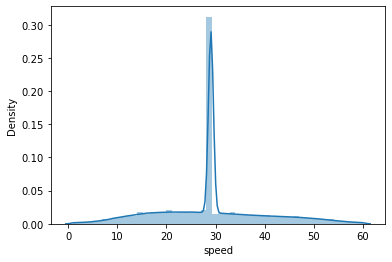

In [16]:
import seaborn as sns
sns.distplot(df_dyna_all["speed"])

In [46]:
# df_dyna=df_dyna_all.loc[(df_dyna_all["time"]<"2020-06-19T00:00:00Z") | (df_dyna_all["time"]>="2020-06-21T00:00:00Z")]

# df_dyna
# df_dyna.to_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}.dyna"), index=False)

,dyna_id,type,time,entity_id,flow
0,0,state,2020-06-01T00:00:00Z,0,24
1,1,state,2020-06-01T00:00:00Z,1,3
2,2,state,2020-06-01T00:00:00Z,2,0
3,3,state,2020-06-01T00:00:00Z,3,0
4,4,state,2020-06-01T00:00:00Z,4,27
...,...,...,...,...,...
1416955,1416955,state,2020-06-30T23:45:00Z,487,0
1416956,1416956,state,2020-06-30T23:45:00Z,488,0
1416957,1416957,state,2020-06-30T23:45:00Z,489,0
1416958,1416958,state,2020-06-30T23:45:00Z,490,0


config

---

In [18]:
import json

config={}

config["geo"]={}
config["geo"]["including_types"]=["LineString"]
config["geo"]["LineString"]={}

config["rel"]={}
config["rel"]["including_types"]=["geo"]
config["rel"]["geo"]={}

config["dyna"]={}
config["dyna"]["including_types"]=["state"]
config["dyna"]["state"]={"entity_id": "geo_id", "flow": "num"}

config["info"]={}
config["info"]["data_files"]=f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered"
config["info"]["geo_file"]=DATASET
config["info"]["rel_file"]=DATASET
config["info"]["data_col"]=["flow"]
config["info"]["output_dim"]=1
# config["info"]["weight_col"]="link_weight"
config["info"]["time_intervals"]=60*FLOW_AGG_INTERVAL_MINUTE
config["info"]["init_weight_inf_or_zero"]="zero" # adj matrix not connected: 0 (inf: infinity)
config["info"]["set_weight_link_or_dist"]="link" # adj matrix 01 (dist: use weight)
config["info"]["calculate_weight_adj"]=False
# config["info"]["weight_adj_epsilon"]=0.1 # disabled when the above is false

json.dump(config, open(os.path.join(DATA_PATH, DATASET, "config.json"), "w", encoding="utf-8"), ensure_ascii=False)
config

{'geo': {'including_types': ['LineString'], 'LineString': {}},
 'rel': {'including_types': ['geo'], 'geo': {}},
 'dyna': {'including_types': ['state'],
  'state': {'entity_id': 'geo_id', 'flow': 'num'}},
 'info': {'data_files': 'sz_taxi_202006_5min_recovered',
  'geo_file': 'sz_taxi_202006',
  'rel_file': 'sz_taxi_202006',
  'data_col': ['speed'],
  'output_dim': 1,
  'time_intervals': 300,
  'init_weight_inf_or_zero': 'zero',
  'set_weight_link_or_dist': 'link',
  'calculate_weight_adj': False}}

dl_traffic

must run in python 3.7

---

In [3]:
import pandas as pd

df_dyna=pd.read_csv(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered.dyna"), parse_dates=["time"])

df_dyna

,dyna_id,type,time,entity_id,flow,speed
0,0,state,2020-06-01 00:00:00+00:00,0,18,42.333333
1,1,state,2020-06-01 00:00:00+00:00,1,2,42.000000
2,2,state,2020-06-01 00:00:00+00:00,2,1,29.057819
3,3,state,2020-06-01 00:00:00+00:00,3,0,29.057819
4,4,state,2020-06-01 00:00:00+00:00,4,13,42.545455
...,...,...,...,...,...,...
3967483,3967483,state,2020-06-30 23:55:00+00:00,487,0,29.057819
3967484,3967484,state,2020-06-30 23:55:00+00:00,488,0,29.057819
3967485,3967485,state,2020-06-30 23:55:00+00:00,489,0,29.057819
3967486,3967486,state,2020-06-30 23:55:00+00:00,490,0,29.057819


In [4]:
df_dlt=pd.DataFrame(columns=range(492))

for row in df_dyna.itertuples():
    df_dlt.loc[row[3], row[4]]=row[5]
    
df_dlt

,0,1,2,3,4,5,6,7,8,9,...,482,483,484,485,486,487,488,489,490,491
2020-06-01 00:00:00+00:00,18,2,1,0,13,5,1,5,5,12,...,6,0,5,3,6,18,10,4,10,6
2020-06-01 00:05:00+00:00,14,0,0,1,11,0,0,3,8,4,...,5,0,5,6,5,20,18,6,12,8
2020-06-01 00:10:00+00:00,20,2,0,0,18,6,0,7,8,12,...,5,0,1,0,3,22,17,13,10,8
2020-06-01 00:15:00+00:00,19,0,1,1,21,5,0,5,7,5,...,2,1,3,3,2,16,4,10,9,12
2020-06-01 00:20:00+00:00,14,2,0,1,16,9,1,10,5,5,...,4,1,7,8,4,16,14,9,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 23:35:00+00:00,0,0,0,0,0,1,0,1,1,0,...,1,0,0,1,1,3,3,0,0,0
2020-06-30 23:40:00+00:00,0,0,1,1,1,0,0,0,1,0,...,0,0,1,0,0,2,1,1,0,1
2020-06-30 23:45:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-06-30 23:50:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_dlt.loc["2020-06-01 23:00:00":"2020-06-01 23:55:00"].mean(axis=1)

2020-06-01 22:00:00+00:00    4.510163
2020-06-01 22:05:00+00:00    4.924797
2020-06-01 22:10:00+00:00    4.575203
2020-06-01 22:15:00+00:00    4.172764
2020-06-01 22:20:00+00:00    3.947154
2020-06-01 22:25:00+00:00    3.869919
2020-06-01 22:30:00+00:00    3.670732
2020-06-01 22:35:00+00:00    3.786585
2020-06-01 22:40:00+00:00    4.319106
2020-06-01 22:45:00+00:00    3.853659
2020-06-01 22:50:00+00:00    3.575203
2020-06-01 22:55:00+00:00    3.414634
dtype: float64

In [17]:
df_dlt.loc["2020-06-14 23:00:00":"2020-06-14 23:55:00"].mean(axis=1)

2020-06-14 23:00:00+00:00    3.871951
2020-06-14 23:05:00+00:00    2.987805
2020-06-14 23:10:00+00:00    2.745935
2020-06-14 23:15:00+00:00    2.219512
2020-06-14 23:20:00+00:00    2.186992
2020-06-14 23:25:00+00:00    1.979675
2020-06-14 23:30:00+00:00    1.552846
2020-06-14 23:35:00+00:00    1.231707
2020-06-14 23:40:00+00:00    0.569106
2020-06-14 23:45:00+00:00    0.209350
2020-06-14 23:50:00+00:00    0.258130
2020-06-14 23:55:00+00:00    1.378049
dtype: float64

In [15]:
df_dlt.loc["2020-06-15 00:00:00":"2020-06-15 00:55:00"].mean(axis=1)

2020-06-15 00:00:00+00:00    6.475610
2020-06-15 00:05:00+00:00    6.105691
2020-06-15 00:10:00+00:00    5.697154
2020-06-15 00:15:00+00:00    5.945122
2020-06-15 00:20:00+00:00    6.119919
2020-06-15 00:25:00+00:00    6.465447
2020-06-15 00:30:00+00:00    6.268293
2020-06-15 00:35:00+00:00    6.294715
2020-06-15 00:40:00+00:00    5.873984
2020-06-15 00:45:00+00:00    5.932927
2020-06-15 00:50:00+00:00    5.439024
2020-06-15 00:55:00+00:00    5.648374
dtype: float64

In [16]:
df_dlt.loc["2020-06-15 01:00:00":"2020-06-15 01:55:00"].mean(axis=1)

2020-06-15 01:00:00+00:00    6.010163
2020-06-15 01:05:00+00:00    5.947154
2020-06-15 01:10:00+00:00    5.032520
2020-06-15 01:15:00+00:00    5.172764
2020-06-15 01:20:00+00:00    5.760163
2020-06-15 01:25:00+00:00    5.333333
2020-06-15 01:30:00+00:00    5.272358
2020-06-15 01:35:00+00:00    4.973577
2020-06-15 01:40:00+00:00    5.180894
2020-06-15 01:45:00+00:00    4.745935
2020-06-15 01:50:00+00:00    4.646341
2020-06-15 01:55:00+00:00    4.508130
dtype: float64

In [5]:
df_dlt.to_pickle(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_dlt.pkl"))

In [6]:
df_dlt=pd.DataFrame(columns=range(492))

for row in df_dyna.itertuples():
    df_dlt.loc[row[3], row[4]]=row[6]
    
df_dlt

,0,1,2,3,4,5,6,7,8,9,...,482,483,484,485,486,487,488,489,490,491
2020-06-01 00:00:00+00:00,42.3333,42,29.0578,29.0578,42.5455,29.0578,29.0578,44.5,24.6667,26.9,...,3,29.0578,24,29.0578,48.5,21.9286,48.7143,34.75,41.5556,45.5
2020-06-01 00:05:00+00:00,30.5,29.0578,29.0578,29.0578,45.5455,29.0578,29.0578,33.6667,18.5714,39.25,...,29.0578,29.0578,27.25,32.5,18,32.9375,40.6471,37,41.2222,60
2020-06-01 00:10:00+00:00,34,20.5,29.0578,29.0578,46.125,29.0578,29.0578,36.2,9.25,42.2727,...,31.6667,29.0578,29.0578,29.0578,23.5,32.0588,40.7647,33.25,41.7143,53
2020-06-01 00:15:00+00:00,31.9231,29.0578,29.0578,29.0578,40.8,36,29.0578,43,20.3333,55.6667,...,29.0578,28,29.0578,29,44,32,30.5,38.2222,50.5,55.4
2020-06-01 00:20:00+00:00,27.9091,29.0578,29.0578,29.0578,42.9231,51,29.0578,43.5,14.5,38.8,...,39,32,20,26,26.5,28.3571,39.25,36.6667,36.375,29.0578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 23:35:00+00:00,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,...,29.0578,29.0578,29.0578,29.0578,29.0578,40.3333,47.6667,29.0578,29.0578,29.0578
2020-06-30 23:40:00+00:00,29.0578,29.0578,29.0578,29.0578,55,29.0578,29.0578,29.0578,32,29.0578,...,29.0578,29.0578,29.0578,29.0578,29.0578,20,25,41,29.0578,29.0578
2020-06-30 23:45:00+00:00,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,...,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578
2020-06-30 23:50:00+00:00,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,...,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578,29.0578


In [7]:
df_dlt.to_pickle(os.path.join(DATA_PATH, DATASET, f"{DATASET}_{FLOW_AGG_INTERVAL_MINUTE}min_recovered_speed_dlt.pkl"))